In [2]:
%matplotlib inline

from imageio import imread
import numpy as np
from skimage import color, filters, img_as_float
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Color Moments

In [3]:
def calc_moment3(arr, moment1):
    cubed = np.mean((arr-moment1)**3)
    return math.pow(abs(cubed),1/3) * (1,-1)[cubed<0]

In [4]:
def calc_moments(arr):
    moment1 = np.mean(arr)
    moment2 = np.mean((arr-moment1)**2)**(1/2)
    moment3 = calc_moment3(arr, moment1)
    return moment1, moment2, moment3

In [5]:
def calc_4_rgb_moments(rgbarr):
    r1, r2, r3 = calc_moments(rgbarr[:, :, 0])
    g1, g2, g3 = calc_moments(rgbarr[:, :, 1])
    b1, b2, b3 = calc_moments(rgbarr[:, :, 2])
    gray = color.rgb2gray(rgbarr)
    gr1, gr2, gr3 = calc_moments(gray)
    return [r1, r2, r3, g1, g2, g3, b1, b2, b3, gr1, gr2, gr3]

# DOOG filter


Based on "Preattentive texture discrimination with early vision mechanisms", Fig. 2.

In [6]:
def G(y0, sigmax, sigmay, x, y):
    # The definition of G seems wrong, I refer original Yang's paper.
    # return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (x**2) + (y- y0/sigmay)**2)
    dimx = len(x)
    dimy = len(y)
    return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (1/2) * (((x/sigmax)**2).reshape(1, dimx) + (((y- y0)/sigmay)**2).reshape(dimy, 1)))

In [7]:
def DOOG2(x, y, sigma, r=3):
    sigmay = sigma
    sigmax = r*sigma
    ya = sigma
    yc = -sigma
    return -G(ya, sigmax, sigmay, x, y) + 2*G(0, sigmax, sigmay, x, y) - G(yc, sigmax, sigmay, x, y)

In [8]:
def DOOG2_weight(sigma, r=3, truncate=4):
    # similar filter size logic as filters.gaussian of scipy.
    lw = int(truncate * sigma + 0.5)
    return DOOG2(np.arange(-lw, lw+1), np.arange(-lw, lw+1), sigma, r)

In [9]:
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html
from scipy.ndimage.filters import convolve

In [10]:
def kernel2feature(img, weights):
    return np.mean([np.mean(convolve(img[:, :, i], weights)) for i in range(3)])

In [11]:
# use global variable for speed
# use sigma of 1, 2, 4, 8

KERNELS = [DOOG2_weight(i) for i in [1, 2, 4, 8]]

In [12]:
def tile2doog_features(tile):
    # to make scale similar
    return [1000*kernel2feature(tile, kernel) for kernel in KERNELS]

# Orientation Filter

In [13]:
from scipy.stats import norm

In [14]:
def DOG(y, sigma1=0.5, sigma2=1.5):
    fy1 = norm.pdf(y, scale=sigma1)
    fy2 = norm.pdf(y, scale=sigma2)
    dog = fy1 - fy2
    return dog

In [43]:
def calc_f1(x, y, sigma):
    fx = norm.pdf(x, scale=sigma).reshape(1, len(x))
    fy = DOG(y).reshape(len(y), 1)
    # should access f1[y][x]
    return fx*fy

In [16]:
from scipy.signal import hilbert

In [42]:
def calc_f1f2(x, y, sigma):
    f1 = calc_f1(x, y, sigma)
    f2 = np.imag(hilbert(f1))
    return f1, f2

In [18]:
def rotation_indices(theta, shape):
    """return ([y1, y2, y3, ...], [x1, x2, x3, ...]). Use for numpy indices"""
    y_lim, x_lim = shape
    cos = math.cos(theta)
    sin = math.sin(theta)
    pairs = [(min(y_lim-1, max(0, int(x*sin + y*cos))),
              min(x_lim-1, max(0, int(x*cos - y*sin))))
            for y in range(y_lim)
            for x in range(x_lim)]
    return list(zip(*pairs))
    

### calc weights

In [41]:
def orientation_weights(theta, sigma, truncate=4):
    # similar filter size logic as filters.gaussian of scipy.
    lw = int(truncate * sigma + 0.5)
    
    x = np.arange(-lw, lw+1)
    y = np.arange(-lw, lw+1)
    f1, f2 = calc_f1f2(x, y, sigma)
    inds = rotation_indices(theta, f1.shape)
    f1r = f1[inds].reshape(f1.shape)
    f2r = f2[inds].reshape(f2.shape)
    return f1r, f2r

In [20]:
def orientation_energy(img, theta, sigma=1.5, truncate=4):
    f1, f2 = orientation_weights(theta, sigma)
    ex2 = convolve(img, f1)**2
    ey2 = convolve(img, f2)**2
    return np.sum(ex2+ey2)

In [21]:
def orientation_12_energy(gray_img):
    return [orientation_energy(gray_img, i*(2*math.pi)/12) for i in range(12)]

# Shape features

In [22]:
from skimage.filters import threshold_otsu

In [23]:
def gray2binary(gray_img):
    threds = threshold_otsu(gray_img)
    return gray_img <= threds

In [24]:
import skimage

### perimeter, area

In [71]:
# Paper says the ratio of the area to the perimeter squared, but inverse is much more common, which is compactness.
# standard definition divide this value with 4pi, but it's not important for our case.

def compactness(img_binary):
    l = skimage.measure.perimeter(img_binary)
    area = img_binary.sum()
    if area == 0:
        return 1, area
    return l**2/area, area

### Moment of inertia

In [26]:
def calc_moment_of_inertia(gray_img):
    # cr, cc = ``M[1, 0] / M[0, 0]``, ``M[0, 1] / M[0, 0]`
    M1 = skimage.measure.moments(gray_img, order=1)
    cr = M1[1, 0]/M1[0, 0]
    cc = M1[0, 1]/M1[0, 0]
    mu2 = skimage.measure.moments_central(gray_img, cr, cc, order=2)
    # paper says shape feature is 4. So I use mu2_20 and mu2_02 as a separate features
    # return (mu2[2, 0]+mu2[0, 2])/mu2[0, 0]
    M0sq = mu2[0, 0]**2
    return mu2[2, 0]/M0sq, mu2[0, 2]/M0sq

In [27]:
from skimage.morphology import convex_hull_image
def ratio_convex_hull(img_bainary, area):
    hull_area = convex_hull_image(img_bainary).sum()
    return area/hull_area

### Combine all shape features

In [62]:
def shape_features(img_gray, img_binary):
    comp, area = compactness(img_binary)
    mom = calc_moment_of_inertia(img_gray)
    if(img_binary.any()):
        ratio3 = ratio_convex_hull(img_binary, area)
    else:
        ratio3 = 1
    return [comp, mom[0], mom[1], ratio3]

## Combine all features

In [29]:
def tile2features(tile, tile_gray, tile_binary):
    rgb_moments12 = calc_4_rgb_moments(tile)
    doog4 = tile2doog_features(tile)
    orientation12 = orientation_12_energy(tile_gray)
    shape4 = shape_features(tile_gray, tile_binary)
    return [elem for arr in [rgb_moments12, doog4, orientation12, shape4]
            for elem in arr]

# img2features

In [30]:
def get_tile(tile_row, tile_col, img, img_gray, img_binary):
    tile_h = int(img.shape[0]/5)
    tile_w = int(img.shape[1]/5)
    y0, y1, x0, x1 = tile_row*tile_h, ((tile_row+1)*tile_h), tile_col*tile_w, (tile_col+1)*tile_w
    tile = img[y0:y1, x0:x1, :]
    tile_gray = img_gray[y0:y1, x0:x1]
    tile_binary = img_binary[y0:y1, x0:x1]
    return tile, tile_gray, tile_binary

In [31]:
def get_tile_features(tile_row, tile_col, img, img_gray, img_binary):
    tile, tile_gray, tile_binary = get_tile(tile_row, tile_col, img, img_gray, img_binary)
    return tile2features(tile, tile_gray, tile_binary)

In [32]:
def img2features(img):
    img_gray = color.rgb2gray(img)
    img_binary = gray2binary(img_gray)
    featuresList = [get_tile_features(row, col, img, img_gray, img_binary) for row in range(5)
                    for col in range(5)]
    return [f for fs in featuresList
               for f in fs]

# Create features and save to dataframe

In [33]:
from models.modelutils import dir2filedict

Using TensorFlow backend.


In [34]:
fdict = dir2filedict("data")

In [35]:
files = sorted(f for fs in fdict.values() for f in fs)

In [36]:
len(files)

11815

In [37]:
sfiles = files[0:100]

In [74]:
%%time
features = img2features(img_as_float(imread(sfiles[0])))

CPU times: user 5min 13s, sys: 4.85 s, total: 5min 17s
Wall time: 5min 19s


In [51]:
img = img_as_float(imread(current))

In [52]:
img_gray = color.rgb2gray(img)
img_binary = gray2binary(img_gray)

In [54]:
tile, tile_gray, tile_binary = get_tile(0, 0, img, img_gray, img_binary)

In [ ]:
plt.imshow(tile)

In [68]:
12*25

300

In [73]:
%%time
get_tile_features(4, 0, img, img_gray, img_binary)

CPU times: user 12.6 s, sys: 224 ms, total: 12.9 s
Wall time: 12.9 s


[0.17663780645996785,
 0.13388818483650991,
 0.1790562405637444,
 0.45921783616722056,
 0.090448400108927296,
 0.11253255424775142,
 0.63165575190198975,
 0.088668042624445692,
 -0.09102980116409842,
 0.41160235357890612,
 0.09373136354096151,
 0.11749422601024906,
 0.097090652420371001,
 0.35264386356278243,
 0.58245945735893301,
 0.72611024917911826,
 273.35018381574099,
 794.23802365940526,
 464.83319261295327,
 1.1750594168455939,
 3.7270755304671992,
 13.024348483947417,
 0.001985955569492534,
 0.012673008714971427,
 0.076911421205177827,
 0.089302055473045455,
 1004.2187080765877,
 308.1145322332207,
 629.54282139382224,
 0.41377645651392486,
 0.24935690943121971,
 0.96715652529606022]

### Below here is too slow.

In [ ]:
current = ""

In [45]:
def files2features(files):
    global current
    res = []
    for f in files:
        current = f
        res.append(img2features(img_as_float(imread(f))))
    return res

In [ ]:
%%time
# flist = list(map(lambda file: img2features(img_as_float(imread(file))), sfiles))
flist = files2features(sfiles)

In [ ]:
len(flist)

In [48]:
current

'data/bay/0000.jpeg'

In [73]:
files[0:5]

['data/bay/0000.jpeg',
 'data/bay/0001.jpeg',
 'data/bay/0002.jpeg',
 'data/bay/0003.jpeg',
 'data/bay/0004.jpeg']

In [74]:
files[1000:1005]

['data/beach/0149.jpeg',
 'data/beach/0150.jpeg',
 'data/beach/0152.jpeg',
 'data/beach/0153.jpeg',
 'data/beach/0154.jpeg']

In [75]:
files[2000:2005]

['data/birds/0283.jpeg',
 'data/birds/0285.jpeg',
 'data/birds/0286.jpeg',
 'data/birds/0287.jpeg',
 'data/birds/0288.jpeg']

# Try and Error

In [3]:
img = img_as_float(imread(target))

In [4]:
img.shape

(386, 687, 3)

In [7]:
tile_h = int(img.shape[0]/5)
tile_w = int(img.shape[1]/5)

In [37]:
img_gray = color.rgb2gray(img)
img_binary = gray2binary(img_gray)

In [40]:
tile_row = 4
tile_col = 0

In [63]:
features = img2features(img)

In [64]:
len(features)

800

In [103]:
features = tile2features(tile, tile_gray, tile_binary)

In [105]:
len(features)

32

In [93]:
kernel2feature(tile, weights)

0.00070527536908725728

In [80]:
DOOG2_weight(2).shape, DOOG2_weight(4).shape, DOOG2_weight(8).shape

((17, 17), (33, 33), (65, 65))

In [95]:
tile2doog_features(tile)

[0.13765982813667971,
 0.49999554479585528,
 0.82583922136457,
 1.0295142695869703]

In [87]:
[kernel2feature(tile, DOOG2_weight(i)) for i in [1, 2, 4, 8, 16]]

[0.00013765982813667972,
 0.00049999554479585528,
 0.00082583922136456999,
 0.0010295142695869704,
 0.0011416206025065398]

In [21]:
# maybe too small?

In [22]:
# sum might be better.

np.sum([np.sum(convolve(tile[:, :, i], weights)) for i in range(3)])

22.31984960550443

In [68]:
np.max(DOOG2_weight(1))

0.041748393641227621

In [69]:
np.max(DOOG2_weight(3))

0.0046387104045808461

In [70]:
np.max(DOOG2_weight(7))

0.00085200803349444118

In [72]:
np.max(DOOG2_weight(7)/  np.linalg.norm(DOOG2_weight(7)))

0.052987915559242309

In [71]:
# https://github.com/pdollar/toolbox/blob/master/filters/FbMake.m
# 0.5, 1, 1.5, 2.0

In [82]:
[np.max(convolve(tile[:, :, i], weights)) for i in range(3)]

[0.071272975969383937, 0.022219196106824542, 0.036144642500056459]

In [83]:
[np.mean(convolve(tile[:, :, i], weights)) for i in range(3)]

[0.00043807751520494033, 0.00071622558181795083, 0.00096152301023888064]

In [84]:
[np.mean(convolve(tile[:, :, i], weights))*1000 for i in range(3)]

[0.43807751520494032, 0.71622558181795082, 0.96152301023888065]

In [63]:
np.max(weights)

0.041748393641227621

In [66]:
# np.max(weights / np.linalg.norm(weights))

0.36606071769805038

In [1]:
target = "data/bay/0001.jpeg"

In [3]:
img = img_as_float(imread(target))

In [4]:
img.shape

(386, 687, 3)

In [7]:
tile_h = int(img.shape[0]/5)
tile_w = int(img.shape[1]/5)

In [6]:
tile_h, tile_w

(77, 137)

In [7]:
tile = img[0:tile_h, 0:tile_w, :]

In [8]:
tile.shape

(77, 137, 3)

In [57]:
len(get_tile_features(4, 0, img, img_gray, img_binary))

32

In [69]:
calc_moment_of_inertia(tile_gray)

(0.45085867714422823, 0.26886279616649378)

In [70]:
shape_features(tile_gray, tile_binary)

[98.156225304209556,
 0.45085867714422823,
 0.26886279616649378,
 0.44021164021164022]

In [63]:
tile2 = img[4*tile_h:(5*tile_h), 0:tile_w, :]
tile2_gray = color.rgb2gray(tile2)
tile2_binary = gray2binary(tile2_gray)

In [71]:
shape_features(tile2_gray, tile2_binary)

[249.52704456687493,
 2.5185166529820617,
 1.7470656368143624,
 0.86001926782273608]

In [45]:
tile_gray.shape

(77, 137)

In [34]:
# should apply to original image, but just apply to tile for trial purpose.
threds = threshold_otsu(tile_gray)
tile_binary = tile_gray <= threds

In [36]:
skimage.measure.perimeter(tile_binary)

571.5452018978109

In [37]:
area = tile_binary.sum()

In [38]:
area

3328

In [56]:
compactness(tile_binary)

(98.156225304209556, 3328)

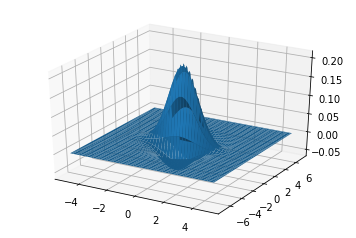

In [32]:
X,Y=np.meshgrid(np.linspace(-5,5,len(x)),np.linspace(-7,7, len(y)));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, f1)
# ax.plot_surface(X, Y, fx*fy, color='red')
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [33]:
theta = 1/(4*math.pi)

In [35]:
inds = rotation_indices(1/(4*math.pi), f1.shape)

In [36]:
len(inds[0])

14000

In [37]:
f1r2 = f1[inds].reshape(f1.shape)

In [41]:
orientation_energy(tile_gray, (2*math.pi)/12)

51.861780304280764

In [42]:
orientation_energy(tile_gray, 0*(2*math.pi)/12)

2.0898866173974229

In [43]:
orientation_energy(tile_gray, 1*(2*math.pi)/12)

51.861780304280764

In [44]:
orientation_energy(tile_gray, 2*(2*math.pi)/12)

18.766855436860915

In [92]:
orientation_energy(tile_gray, 3*(2*math.pi)/12)

0.010338172986608721

In [93]:
[orientation_energy(tile_gray, i*(2*math.pi)/12) for i in range(12)]

[2.0898866173974229,
 51.861780304280764,
 18.766855436860915,
 0.010338172986608721,
 0.089705818498873713,
 0.41842571651551119,
 6.6475988898296573e-05,
 0.00061898107480311694,
 0.0041911733544362966,
 0.0046325663918409454,
 67.778711023843286,
 46.569291894587508]

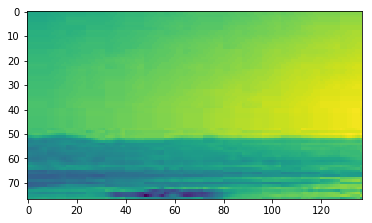

In [101]:
plt.imshow(tile_gray)

In [99]:
tile_gray.shape

(77, 137)

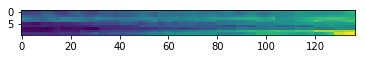

In [105]:
plt.imshow(tile_gray[60:70, :])

In [107]:
[orientation_energy(tile_gray[60:70, 0:60], i*(2*math.pi)/12) for i in range(12)]

[0.12653848807650903,
 1.779355973948693,
 0.59856313259303529,
 0.00035272497014036909,
 0.0025774499529571913,
 0.012898175596365091,
 2.2175847562225684e-06,
 2.1348975458477135e-05,
 0.00014528579077996317,
 0.00015551406705520887,
 2.3283209727642902,
 1.6392639280727841]

In [116]:
img.shape

(386, 687, 3)

In [117]:
tile_w

77

In [124]:
tile2 = img[4*tile_w:(5*tile_w), 0:tile_h, :]

In [125]:
tile2_gray = color.rgb2gray(tile2)

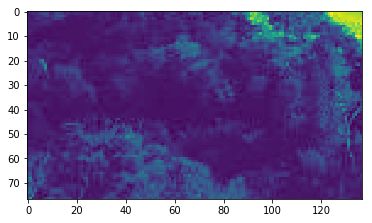

In [126]:
plt.imshow(tile2_gray)

In [129]:
[orientation_energy(tile2_gray, i*(2*math.pi)/12) for i in range(12)]

[4.869461932876205,
 7.1955365848890906,
 1.6050420156037013,
 0.014523668718819925,
 0.017492950842396486,
 0.024533722697677202,
 4.5751296488891631e-06,
 5.2186387453645893e-05,
 0.00034820923876056643,
 0.00035182277156667525,
 6.5269911924616899,
 7.2722472732760943]

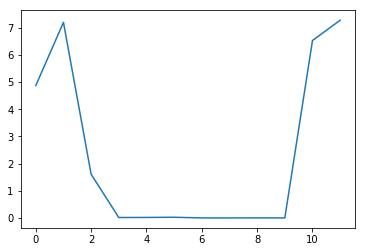

In [130]:
plt.plot(Out[129])

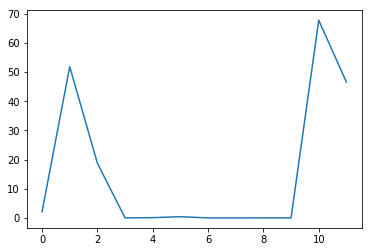

In [131]:
plt.plot(Out[93])

In [56]:
f1[0][4]

-5.0339499764591086e-11

In [50]:
f1[0][3]

-3.1620006979825382e-11

In [52]:
skimage.measure.moments(tile_gray, order=2)

array([[  6.04632279e+03,   2.20937014e+05,   1.08835769e+07],
       [  4.26940422e+05,   1.56406304e+07,   7.71974376e+08],
       [  3.96107262e+07,   1.45428178e+09,   7.19158387e+10]])

In [53]:
skimage.measure.moments(tile_gray, order=1)

array([[  6.04632279e+03,   2.20937014e+05],
       [  4.26940422e+05,   1.56406304e+07]])

In [54]:
skimage.measure.moments(tile_gray, order=0)

array([[ 6046.3227851]])

In [39]:
# cr, cc = ``M[1, 0] / M[0, 0]``, ``M[0, 1] / M[0, 0]`
M1 = skimage.measure.moments(tile_gray, order=1)
cr = M1[1, 0]/M1[0, 0]
cc = M1[0, 1]/M1[0, 0]

In [56]:
skimage.measure.moments_central(tile_gray, cr, cc, order=2)

array([[  6.04632279e+03,  -2.06003407e+05,   9.82909127e+06],
       [  2.06003407e+05,  -6.97879477e+06,   3.32715995e+08],
       [  1.64825002e+07,  -5.57613049e+08,   2.65970581e+10]])

In [40]:
mu2 = skimage.measure.moments_central(tile_gray, cr, cc, order=2)

In [41]:
moment_of_inertia = (mu2[2, 0]+mu2[0, 2])/mu2[0, 0]

In [42]:
moment_of_inertia

4351.6683430028861

In [71]:
convex_hull_image(tile_binary)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [72]:
ratio3 = area/convex_hull_image(tile_binary).sum()

In [73]:
ratio3

0.44021164021164022

In [52]:
ratio_convex_hull(tile_binary, area)

0.44021164021164022

In [75]:
convex_hull_image(tile_binary).sum()

7560

### Check result

In [44]:
f1r = np.zeros_like(f1)

In [48]:
y_lim, x_lim = f1.shape

In [77]:
y_lim, x_lim = f1.shape

for x in range(x_lim):
    for y in range(y_lim):
        x1 = min(x_lim-1, max(0, int(x*math.cos(theta) - y*math.sin(theta))))
        y1 = min(y_lim-1, max(0, int(x*math.sin(theta) + y*math.cos(theta))))
        f1r[y][x] = f1[y1][x1]

In [93]:
inds[0][100*20+52],inds[1][100*20+52]

(24, 50)

In [94]:
f1r[20, 52]

-0.00096289672323596729

In [95]:
f1[24, 50]

-0.00096289672323596729

In [104]:
np.equal(f1r2, f1r).all()

True

In [101]:
f1r2[20, 52]

-0.00096289672323596729

In [14]:
gausres = G(1.5, 2, 2, np.arange(-5, 5), np.arange(-5, 5))

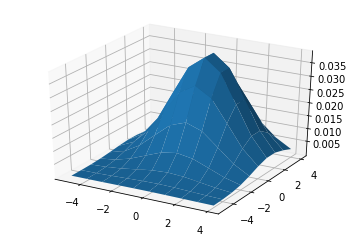

In [16]:

X,Y=np.meshgrid(np.linspace(-5,4,10),np.linspace(-5,4,10));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, gausres)
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [18]:
DOOG2(np.arange(0, 5), np.arange(0, 5), 4, 2)

array([[ 0.00391391,  0.00388345,  0.00379349,  0.00364817,  0.00345402],
       [ 0.0036098 ,  0.00358171,  0.00349874,  0.0033647 ,  0.00318564],
       [ 0.00277449,  0.0027529 ,  0.00268913,  0.00258611,  0.00244848],
       [ 0.00161234,  0.0015998 ,  0.00156274,  0.00150287,  0.00142289],
       [ 0.00038658,  0.00038357,  0.00037468,  0.00036033,  0.00034115]])

In [20]:
DOOG2_weight(7.5)

array([[ -4.04866735e-06,  -4.29159896e-06,  -4.54013015e-06, ...,
         -4.54013015e-06,  -4.29159896e-06,  -4.04866735e-06],
       [ -5.93224151e-06,  -6.28819295e-06,  -6.65234908e-06, ...,
         -6.65234908e-06,  -6.28819295e-06,  -5.93224151e-06],
       [ -8.52716584e-06,  -9.03882017e-06,  -9.56226812e-06, ...,
         -9.56226812e-06,  -9.03882017e-06,  -8.52716584e-06],
       ..., 
       [ -8.52716584e-06,  -9.03882017e-06,  -9.56226812e-06, ...,
         -9.56226812e-06,  -9.03882017e-06,  -8.52716584e-06],
       [ -5.93224151e-06,  -6.28819295e-06,  -6.65234908e-06, ...,
         -6.65234908e-06,  -6.28819295e-06,  -5.93224151e-06],
       [ -4.04866735e-06,  -4.29159896e-06,  -4.54013015e-06, ...,
         -4.54013015e-06,  -4.29159896e-06,  -4.04866735e-06]])

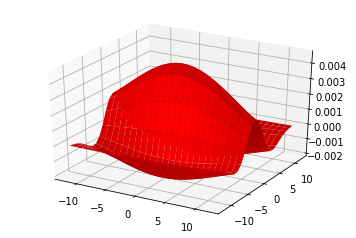

In [24]:
X,Y=np.meshgrid(np.linspace(-12,12,25),np.linspace(-12,12, 25));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, weights, color='red')
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [25]:
np.mean([np.mean(convolve(tile[:, :, i], weights)) for i in range(3)])

0.00070527536908725728

In [30]:
dog = DOG(np.arange(-5, 5, 0.1))

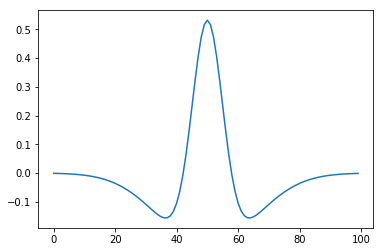

In [31]:
plt.plot(dog)

In [65]:
int(4 * 1.5 + 0.5)

6

In [66]:
x = np.arange(-6, 6+1)
y = np.arange(-6, 6+1)

In [67]:
f1, f2 = calc_f1f2(x, y)

In [68]:
inds = rotation_indices((2*math.pi)/12, f1.shape)

In [69]:
f1r = f1[inds].reshape(f1.shape)

In [113]:
np.arange(5).reshape(5, 1)*np.arange(5,10).reshape(1, 5)

array([[ 0,  0,  0,  0,  0],
       [ 5,  6,  7,  8,  9],
       [10, 12, 14, 16, 18],
       [15, 18, 21, 24, 27],
       [20, 24, 28, 32, 36]])

In [122]:
np.arange(5).reshape(1, 5)*np.arange(5,10).reshape(5, 1)

array([[ 0,  5, 10, 15, 20],
       [ 0,  6, 12, 18, 24],
       [ 0,  7, 14, 21, 28],
       [ 0,  8, 16, 24, 32],
       [ 0,  9, 18, 27, 36]])

In [126]:
(np.arange(5).reshape(1, 5)*np.arange(5,10).reshape(5, 1))[1][3]

18

In [127]:
np.arange(3).reshape(1, 3)*np.arange(5,10).reshape(5, 1)

array([[ 0,  5, 10],
       [ 0,  6, 12],
       [ 0,  7, 14],
       [ 0,  8, 16],
       [ 0,  9, 18]])

In [112]:
np.arange(5).reshape(1, 5)[0]

array([0, 1, 2, 3, 4])

In [ ]:
tmp = norm.pdf(np.arange(-10, 10, 0.1), scale=5)
plt.plot(np.arange(-10, 10, 0.1), tmp)

In [11]:
calc_moments(tile[:, :, 0])

(0.37209400017472155, 0.10217063437619424, -0.09780083132038393)

In [21]:
color.rgb2gray(tile[0:3, 0:3, :])

array([[ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51777176,  0.51777176,  0.51777176]])

In [26]:
tmp = tile[0:3, 0:3, :]

In [27]:
[calc_moments(tmp[:, :, i]) for i in range(3)]

[(0.25882352941176467, 0.0055459355387180269, 0.15959603823333823),
 (0.56470588235294117, 0.0, -0.241661910774848),
 (0.78954248366013069, 0.0018486451795726665, -0.44268744485027073)]

In [28]:
len(calc_4_moments(tmp))

12

In [29]:
calc_4_moments(tile)

[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.2781541238099151,
 0.8166978005535328,
 0.05321479042159858,
 -0.4683674599313368,
 0.5731654929470128,
 0.073980597551597832,
 -0.2485871934295749]

In [19]:
def gray_arr(rgbarr):
    return (rgbarr[:, :, 0]+rgbarr[:, :, 1]+rgbarr[:, :, 2])/3

In [20]:
gray_arr(tile[0:3, 0:3, :])

array([[ 0.53594771,  0.53594771,  0.53594771],
       [ 0.53594771,  0.53594771,  0.53594771],
       [ 0.54117647,  0.54117647,  0.54117647]])

In [21]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [22]:
tile[0:3, 0:3, 1]

Image([[144, 144, 144],
       [144, 144, 144],
       [144, 144, 144]])

In [23]:
tile[0:3, 0:3, 2]

Image([[201, 201, 201],
       [201, 201, 201],
       [202, 202, 202]])

In [24]:
(tile[0:3, 0:3, 0]+tile[0:3, 0:3, 1]+tile[0:3, 0:3, 2])/3

Image([[ 136.66666667,  136.66666667,  136.66666667],
       [ 136.66666667,  136.66666667,  136.66666667],
       [ 138.        ,  138.        ,  138.        ]])

In [9]:
r_1_moment = np.mean(tile[:, :, 0])

In [10]:
r_1_moment

94.88397004455399

In [11]:
np.sum(tile[:, :, 0])/(tile.shape[0]*tile.shape[1])

94.88397004455399

In [12]:
import math

In [13]:
np.sum((tile[:, :, 0]-r_1_moment)**2)/(tile.shape[0]*tile.shape[1])

678.78547533742858

In [14]:
np.mean((tile[:, :, 0]-r_1_moment)**2)

678.78547533742858

In [15]:
r_2_moment = np.mean((tile[:, :, 0]-r_1_moment)**2)**(1/2)

In [16]:
r_2_moment

26.053511765929532

In [73]:
math.sqrt(np.mean((tile[:, :, 0]-r_1_moment)**2))

26.05351176592953

In [81]:
r_3_moment = (np.mean((tile[:, :, 0]-r_1_moment)**3))**(1./3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [68]:
r_3_moment

nan

In [91]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [85]:
type(np.mean((tile[:, :, 0]-r_1_moment)**3))

numpy.float64

In [82]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [88]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [89]:
r_3_moment

nan

In [105]:
-15511.299389127838**(1/3)

-24.93921198669789

In [100]:
(-15511.299389127838)**(1/3)

(12.46960599334895+21.597991130845752j)

In [95]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [97]:
(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float))**(1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

Negative cuberoot return complex answer (it also valid from the methematical point of view, but not what people want)

- https://stackoverflow.com/questions/1361740/cubic-root-of-the-negative-number-on-python
- https://stackoverflow.com/questions/45906383/python-exponent-operator-with-fractional-exponents

In [107]:
calc_moment3(tile[:, :, 0], r_1_moment)

-24.93921198669789

In [108]:
r_3_moment = moment3(tile[:, :, 0], r_1_moment)

In [109]:
r_1_moment, r_2_moment, r_3_moment

(94.88397004455399, 26.053511765929532, -24.93921198669789)

In [113]:
calc_moments(tile[:, :, 1])

(155.12854298985687, 17.769411514261186, -70.92930157152836)

In [114]:
calc_moments(tile[:, :, 2])

(208.25793914115081, 13.569771557507638, -119.4337022824908)

In [32]:
tmp = np.array([3, 4, 5])

In [33]:
tmp**2

array([ 9, 16, 25])

In [34]:
tmp**3

array([ 27,  64, 125])

In [39]:
itile = tile.astype(int)

In [43]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]], dtype=uint8)

In [40]:
itile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [41]:
itile[0:3, 0:3, 0]**2

Image([[4225, 4225, 4225],
       [4225, 4225, 4225],
       [4624, 4624, 4624]])

In [42]:
itile[0:3, 0:3, 0]**3

Image([[274625, 274625, 274625],
       [274625, 274625, 274625],
       [314432, 314432, 314432]])